<a href="https://colab.research.google.com/github/osh9149/2023_DataScience/blob/main/OpenCV_%EC%B9%B4%EB%A9%94%EB%9D%BC%EC%8A%A4%ED%8B%B0%EC%BB%A4_%EC%95%B1_%EB%A7%8C%EB%93%A4%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#OpenCV(Open Source Computer Vision Library)

1.   500여개 이상의 함수와 알고리즘
2.   Computer Vision, Image Processing을 할 수 있음


#0.라이브러리 설치하기

In [ ]:
!pip install opencv-python
!pip install cmake
!pip install dlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#1. 필요 라이브러리 import

In [ ]:
import cv2, math
import matplotlib.pyplot as plt
import numpy as np
import dlib
import os #chdir사용시 필요함
import glob #파일 경로
from google.colab.patches import cv2_imshow

#구글 드라이브 마운트

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#2. opencv로 이미지 읽어오기

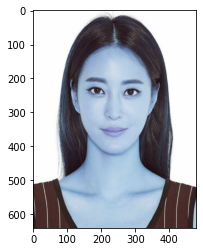

In [ ]:
my_image_path='/content/drive/MyDrive/sticker/test.jpg' #불러올 파일

img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (480, 640))    # 640x480의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

# plt.imshow 이전에 RGB 이미지로 변경
# opencv는 RGB 대신 BGR을 사용하기 때문에 RGB로 변경해주어야 한다.

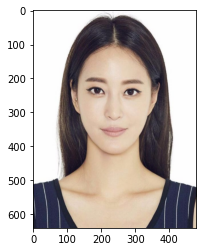

In [ ]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

#3. 얼굴 검출 (Face Detection)

rectangles[[(111, 171) (379, 439)]]


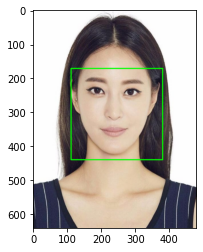

In [ ]:
# hog detector 선언
detector_hog = dlib.get_frontal_face_detector()

# bounding box 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

# 찾은 얼굴영역 출력
print(dlib_rects)   # 찾은 얼굴영역 좌표
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

#4. 얼굴 랜드마크 (Face Landmark)

이목구비의 위치를 추론하는 것을 face landmark localization 기술이라고 한다. face landmark는 detection의 결과물인 bounding box로 잘라낸(crop) 얼굴 이미지를 이용한다.
*   Object keypoint estimation 알고리즘 : 객체 내부의 점을 찾는 기술
*   top-down : bounding box를 찾고 box 내부의 keypoint를 예측
*   bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성
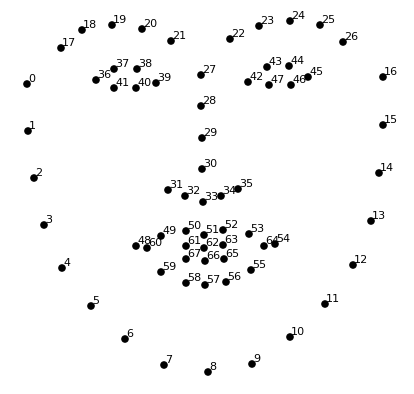

In [ ]:
# landmark 모델 불러오기
model_path = '/content/drive/MyDrive/sticker/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# landmark 찾기
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))



68


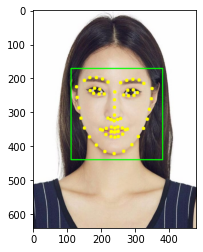

In [ ]:
# landmark 출력
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 5, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

#5. 스티커 적용하기

In [ ]:
# 좌표 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.height()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(238, 308)
(x,y) : (238,174)
(w,h) : (269,269)


(224, 224, 3)


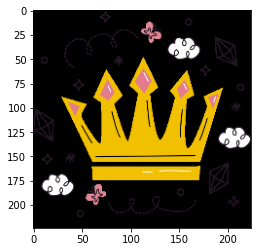

(x,y) : (130,-28)
(196, 224, 3)
(x,y) : (130,0)


In [ ]:
# 스티커 이미지 Read
import os
sticker_path = '/content/drive/MyDrive/sticker/crown.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)  #높이, 너비, 채널

img_show_rgb = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# 스티커 이미지 좌표
refined_x = x - w // 2  # left
refined_y = y - h       # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

# y좌표가 음수일 때, -y만큼 이미지를 잘라준 후 y 경계값은 0으로 설정
img_sticker = img_sticker[-refined_y:]
print (img_sticker.shape)
refined_y = 0
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

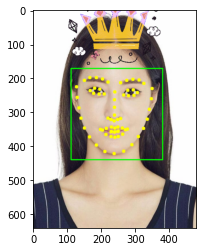

In [ ]:
# 원본에 스티커 적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

# 결과 이미지 출력
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()


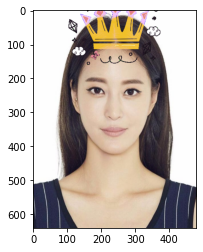

In [ ]:
# bounding box 제거 후 이미지
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

#연습문제> 고양이 수염 스티커 만들기

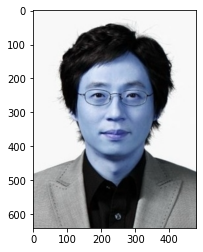

In [ ]:
my_image_path='/content/drive/MyDrive/sticker/test2.jpg' #불러올 파일

img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (480, 640))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()


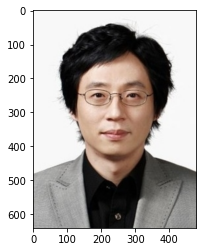

In [ ]:
#BGR--> RGB로 변경

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

rectangles[[(117, 192) (340, 415)]]


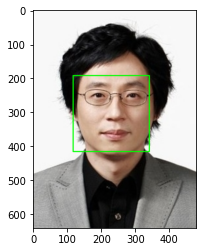

In [ ]:
# hog detector 선언
detector_hog = dlib.get_frontal_face_detector()

# bounding box 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

# 찾은 얼굴영역 출력
print(dlib_rects)   # 찾은 얼굴영역 좌표
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [ ]:
# landmark 모델 불러오기
model_path = '/content/drive/MyDrive/sticker/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# landmark 찾기
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


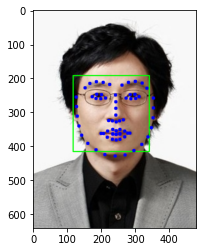

In [ ]:
# landmark 출력
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 5, (255, 0, 0), -1) # blue

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [ ]:
# 좌표 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.height()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(242, 308)
(x,y) : (242,196)
(w,h) : (224,224)


(224, 224, 3)


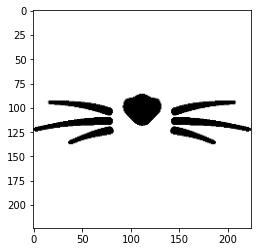

(x,y) : (130,196)


In [ ]:
# 스티커 이미지 Read
import os
sticker_path = '/content/drive/MyDrive/sticker/mustache.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

img_show_rgb = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()


# 스티커 이미지 좌표
refined_x = x - w // 2  # left
refined_y = y        # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

# y좌표가 음수일 때, -y만큼 이미지를 잘라준 후 y 경계값은 0으로 설정
# img_sticker = img_sticker[-refined_y:]
# print (img_sticker.shape)
# refined_y = 0
# print ('(x,y) : (%d,%d)'%(refined_x, refined_y))



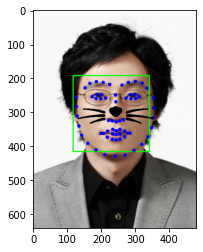

In [ ]:
# 원본에 스티커 적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)


# 결과 이미지 출력
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()




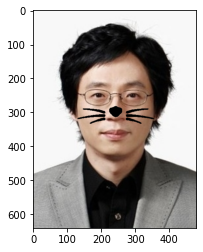

In [ ]:
# bounding box 제거 후 이미지
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker, sticker_area).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

#만약 얼굴이 정면이 아니라면 각도를 조절해야함(생각해보기)